In [1]:
import os
import string
import torch
from torch import nn
from torch.nn import functional as F
if not "CHDIR_FLAG" in dir():
    os.chdir("../")
    CHDIR_FLAG = True
    
import numpy as np
import pandas as pd
from safetensors import safe_open
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.tools.transformers import greedy_decode
from src.tools.plot import plot_tensor_mean_and_variance, plot_tensor_histogram, plot_tensor_heatmap
from src.tools.torch import register_forward_hook_decorator, register_backward_hook_decorator

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
torch.__version__

'2.6.0+cpu'

# Preliminary

1. 在之前的研究中，我们发现靠后的层具有更重要的作用？是否有可能丢弃一些不重要的层？
  - 实验验证发现，即便跳过一些隐层，并不影响输出的可行性，
  
2. 同理在之前针对LoRA块的奇异值分析中发现，某些情况下，v_proj 的确是低秩的，远远不如 q_proj 和 k_proj，猜想为 v_proj 可能不值得调优
  
  
引出可能的研究思路：

1. 是否在PEFT中可以只对包含信息量多的层的QKV进行微调

  - 所谓包含信息多的层，指的是层的输入和输出差异较大
  - **但是这件事情反过来说也是一样的，也许其他层输入输出差异小，因此包含的信息少，可能就是模型留出的“容量”来学习其他知识，因此更需要去微调**
2. 这件事本身也可以和QKV LoRA块的信息量进行交叉验证
3. Layer-Skip的可行性？若可行，则探讨Skip的组合方法？

In [2]:
model_home = r"D:\resource\model\huggingface"
model_names = [
    r"Qwen\Qwen2.5-0.5B-Instruct",
    r"deepseek-ai\DeepSeek-R1-Distill-Qwen-1.5B",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-3.pt",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-3.pt",
]

# -*- coding: utf8 -*-
# @author: caoyang
# @email: caoyang@stu.sufe.edu.cn

import logging
from copy import deepcopy
from functools import wraps
from src.tools.hook import register_forward_hook_decorator, register_backward_hook_decorator

def get_generation_eos_token_ids(model):
    eos_token_id = model.generation_config.eos_token_id
    if isinstance(eos_token_id, int):
        eos_token_ids = [eos_token_id]
    elif isinstance(eos_token_id, list):
        eos_token_ids = eos_token_id[:]
    else:
        logging.warning(f"Unknown type of EOS: {eos_token_id}")
        eos_token_ids = [151643, 151645]	# Default EOS token for Qwen model
    return eos_token_ids

def get_generation_bos_token_ids(model):
    bos_token_id = model.generation_config.bos_token_id
    if isinstance(bos_token_id, int):
        bos_token_ids = [bos_token_id]
    elif isinstance(bos_token_id, list):
        bos_token_ids = bos_token_id[:]
    else:
        logging.warning(f"Unknown type of BOS: {bos_token_id}")
        bos_token_ids = [151646]	# Default EOS token for Qwen model
    return bos_token_ids	

# Standard greedy decode supporting hook registration
# @param model: Huggingface model object
# @param tokenizer: Huggingface tokenizer Object
# @param prompt: [Str]
# @param max_length: [Int]the number of tokens to be generated (exclude `prompt`)
# @param device: [Str] e.g. "cuda" or "cpu"
# @param use_kv_cache: [Boolean] whether to use KV-cache to accelerate, if True then large memory will be consumed
# @param forward_hook_module_names: [List[Str]] Default None, otherwise register forward hook for `forward_hook_module_names`, e.g. ["model.layers[0].self_attn.q_proj", "model.layers[0].self_attn.k_proj"]
# @param backward_hook_module_names: [List[Str]] Default None, otherwise register backward hook for `backward_hook_module_names`, e.g. ["model.layers[0].self_attn.q_proj", "model.layers[0].self_attn.k_proj"]
# @return returned_dict: [Dict]
# - "text": [Str]
# - "token_probs": List[Tuple(Int, Str, Float)], `len(generated_id_prob)` is `max_length`, indicating the generated probability of each token
# - "logits": Tuple[FloatTensor(1, n_vocab)], `len(generated_logits)` is `max_length`, indicating the logits when each token is generated
# - "forward_hook_data": List of hook data (length is `max_length`) in format of [Dict[<module_name>: Dict]], Read `hook_data` in `src.tools.hook.register_forward_hook_decorator` for details
# - "backward_hook_data": List of hook data (length is `max_length`) in format of [Dict[<module_name>: Dict]], Read `hook_data` in `src.tools.hook.register_backward_hook_decorator` for details
def greedy_decode(model,
                  tokenizer,
                  prompt, 
                  max_length,
                  device = "cuda",
                  use_kv_cache = True,
                  forward_hook_module_names = None,
                  backward_hook_module_names = None,
                  skip_layer_idx = list(),
                  layer_order = None,
                  ):
    if forward_hook_module_names is None and backward_hook_module_names is None:
        hook_flag = 0
        def easy_forward(inputs, *, model, **kwargs):
            return model(inputs, **kwargs)
    elif not (forward_hook_module_names is None or backward_hook_module_names is None):
        hook_flag = -1
        raise NotImplementedError("Simultaneous use of forward and backward hook!")
    else:
        if forward_hook_module_names is not None:
            hook_flag = 1
            @register_forward_hook_decorator(module_names = forward_hook_module_names)
            def easy_forward(inputs, *, model, **kwargs):
                return model(inputs, **kwargs)
        else:
            hook_flag = 2
            @register_backward_hook_decorator(module_names = forward_hook_module_names)
            def easy_forward(inputs, *, model, **kwargs):
                return model(inputs, **kwargs)

    eos_token_ids = get_generation_eos_token_ids(model)
    logging.info(f"EOS token: {eos_token_ids}")
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)	# Str => Long(1, n_tokens)
    past_key_values = None
    generated_token_probs = list()
    generated_logits = list()
    forward_hook_data = None
    backward_hook_data = None
    if hook_flag == 1:
        forward_hook_data = list()
    if hook_flag == 2:
        backward_hook_data = list()	
    for i in range(max_length):
        # logging.info(f"Round {i}: {past_key_values.key_cache[0].size() if past_key_values is not None else None}")
        with torch.no_grad():
            if use_kv_cache:
                if past_key_values is None:
                    outputs = easy_forward(inputs, model=model, past_key_values=None, skip_layer_idx=skip_layer_idx, layer_order=layer_order)
                else:
                    outputs = easy_forward(inputs[:, -1].unsqueeze(0), model=model, past_key_values=past_key_values, use_cache=True, skip_layer_idx=skip_layer_idx, layer_order=layer_order)
                past_key_values = outputs.past_key_values	# Dictlike[key_cache: Float(1, 2, X, hidden_size), value_cache: Float(1, 2, X, hidden_size)], where X = (i + 1) * (n_tokens + i / 2)
            else:
                outputs = easy_forward(inputs, model=model, past_key_values=None, use_cache=False, skip_layer_idx=skip_layer_idx, layer_order=layer_order)
            logits = outputs.logits	# Float(1, n_tokens + i + 1, n_vocab), where `n_vocab` is 151936 in Qwen-series
            next_token_probs = F.softmax(logits[:, -1, :], dim=-1)	# Float(1, n_tokens + i + 1, n_vocab) => Float(1, n_vocab)
            next_token_id = torch.argmax(next_token_probs, dim=-1)	# Float(1, n_vocab) => Long(1, )
            next_token_prob = next_token_probs[0, next_token_id].item()	# Float(1, n_vocab) => Float()
            next_token = tokenizer.decode(next_token_id[0].item(), skip_special_tokens=False)	# Long(1, ) => Str
            inputs = torch.cat([inputs, next_token_id.unsqueeze(-1)], dim=-1)	# Long(1, n_tokens + i) => Long(1, n_tokens + i + 1)
            generated_token_probs.append((next_token_id.item(), next_token, next_token_prob))	# List[] <- (Int, Str, Float)
            generated_logits.append(logits[:, -1, :])	# List[] <- Float(1, n_vocab)
            # Process hook data
            if hook_flag > 0:
                hook_data = outputs.hook_outputs
                if hook_flag == 1:
                    forward_hook_data.append(hook_data)
                else:
                    backward_hook_data.append(hook_data)
            if next_token_id in eos_token_ids:
                # Early stop at EOS
                break
    generated_text = tokenizer.decode(
        token_ids = inputs[0], 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=True,
    )	# Long(1, n_tokens + max_length) => Str
    return {
        "text": generated_text,
        "token_probs": generated_token_probs,
        "logits": tuple(generated_logits),
        "forward_hook_data": forward_hook_data,
        "backward_hook_data": backward_hook_data,
    }

# Skip-Layer生成案例分析（Qwen2.5B-Instruct）

目前测试方法是给 `Qwen2Model` 源码加了一个参数 `skip_layer_idx`

修改：`E:\Anaconda3\envs\myopenai\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py` 的516行加了参数 `skip_layer_idx`，然后在570行左右加入 `skip_layer_idx` 的操作：

```python
for i, decoder_layer in enumerate(self.layers[: self.config.num_hidden_layers]):
    if i in skip_layer_idx:
        continue
    if output_hidden_states:
        all_hidden_states += (hidden_states,)

    if self.gradient_checkpointing and self.training:
        layer_outputs = self._gradient_checkpointing_func(
            decoder_layer.__call__,
            hidden_states,
            causal_mask,
            position_ids,
            past_key_values,
            output_attentions,
            use_cache,
            cache_position,
            position_embeddings,
        )
    else:
        layer_outputs = decoder_layer(
            hidden_states,
            attention_mask=causal_mask,
            position_ids=position_ids,
            past_key_value=past_key_values,
            output_attentions=output_attentions,
            use_cache=use_cache,
            cache_position=cache_position,
            position_embeddings=position_embeddings,
            **flash_attn_kwargs,
        )
```

针对 `Qwen2.5-0.5B-Instruct` 已经测出的一些结果：

1. `skip_layer_idx = [8]`，依然可以正常输出

In [3]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(model_home, model_names[0]))
model = AutoModelForCausalLM.from_pretrained(os.path.join(model_home, model_names[0]))

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
prompt = "For how many positive integers n > 1 is"
max_length = 128

In [5]:
# 标准的解码生成结果
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])

For how many positive integers n > 1 is 1^n + 2^n + 3^n + 4^n a multiple of 15?
To determine for how many positive integers \( n > 1 \) the expression \( 1^n + 2^n + 3^n + 4^n \) is a multiple of 15, we need to analyze the expression modulo 15. We will consider the possible values of \( n \mod 15 \) and determine the corresponding values of \( 1^n + 2^n + 3^n + 4^n \mod 15 \).

First, note that \( 1^n


## Case 1 很久很久以前，

In [5]:
prompt = "很久很久以前"
max_length = 128

### 标准输出

In [6]:
# 标准的解码生成结果
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])

很久很久以前，我有一个朋友，他是个非常有才华的人，他总是喜欢在自己的作品中加入一些独特的元素，比如用不同的颜色、不同的形状、不同的纹理等，使作品更加生动有趣。他的作品经常被一些知名艺术家的作品所借鉴和模仿，甚至在一些艺术展览上展出。他的作品受到了很多人的喜爱和追捧，甚至有人认为他是当代艺术的先驱者。

然而，随着时间的推移，我发现他似乎不再像以前那样有才华了。他的作品不再那么独特，也不再有那么多的创新性。他的作品变得越来越平庸，不再有那么大的艺术


In [9]:
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])
df

,id,token,prob
0,3837,，,0.574743
1,35946,我,0.056853
2,104133,有一个,0.042239
3,99614,朋友,0.173688
4,3837,，,0.300132
5,42411,他,0.269007
6,104104,是个,0.066669
7,99491,非常,0.054581
8,18830,有,0.137744
9,112283,才华,0.237275


### skip 1

In [59]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])

0 很久很久以前él_í   -- .1      ""  มより                  " " from to to from from from from to a a to to to to to to A to A to A
1 很久很久以前 、 这座猫耳朵， 19200 190000 19. 
 1900
2000
I'm 20000 20000 20000 19000 
2 很久很久以前以前以前以前以前以前以前以前以前以前以前以前以前以前以前以前以前,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在,在
3 很久很久以前，我总是觉得我身体不舒服，有时候会感觉头晕，有时候会感觉恶心，有时候会感觉胸闷，有时候会感觉心慌，有时候会感觉呼吸不畅，有时候会感觉呼吸不畅，有时候会感觉呼吸不畅，有时候会感觉呼吸不畅，有时候会感觉呼吸不畅
4 很久很久以前，我曾去过一个叫“小城”的地方。现在，我回到了“小城”。我必须在“小城”里找到我曾经去过的地方。 这个句子的逻辑关系是____。
A. 递进
B. 转折
C. 递进+转折
5 很久很久以前，我有一个朋友，他总是说“我不会”，但有时候会说“我可能不会”。我应该怎样做？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？
6 很久很久以前，人们就发现，当一个人在做某件事时，大脑中会涌现出一种“做不完”的想法，这种想法会一直持续到他完成某件事为止。这种现象被称为“做不完”效应。以下选项中，哪一个最能解释“做不完”效应的现象？
A. 人们
7 很久很久以前，我父亲的病床旁，我常常会想起他，想起他，想起他……
我常常会想起他，想起他，想起他……
我常常会想起他，想起他，想起他……
我常常会想起他，想起他，想起他……
我常常会想起
8 很久很久以前，我曾是一名普通的上班族，每天早上起床后，我都会去公园散步，然后在公园里，我都会看到一只小猫，我叫小猫，它会用爪子蹭我的腿，然后我会很开心，我也会用脚去蹭它的脚，然后它就会用爪子
9 很久很久以前，我曾因一次意外而受伤，导致右脚踝扭伤，当时没有在意，后来就一直没注意，直到现在，右脚踝一直肿胀，疼痛，走路时脚踝会有点痛，但不肿，现在脚踝肿胀，疼痛，走路时脚踝会有点
10 很久很久以前，我有一个朋友，他是个非常有才

### skip 2 or more randomly

In [71]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [10, 11],
)
print(results["text"])

很久很久以前，我有一个朋友，他是个非常有才华的人，他总是能从别人身上学到很多东西。他总是能从别人身上学到很多东西，这让我感到很惊讶。我经常在想，如果我能够从别人身上学到很多东西，我是不是也能从别人身上学到呢？ 你


In [77]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [10, 11, 12],
)
print(results["text"])

很久很久以前，我有一个朋友，他是一位非常优秀的科学家，他是一位非常优秀的科学家。他是一位非常优秀的科学家，并且在科学领域有着非常高的成就。但是，最近他发现他的研究领域被一些不公正的言论所影响了。他开始怀疑自己的研究是否正确，并且开始怀疑自己的科学知识。他开始怀疑自己的科学知识是否正确，并且开始怀疑自己的科学知识是否正确。 请问，为什么他开始怀疑自己的科学知识是否正确呢？ 他开始怀疑自己的科学知识是否正确，可能是因为他开始怀疑自己的科学知识是否正确，可能是因为他开始怀疑自己的科学知识是否正确


In [64]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [3, 4],
)
print(results["text"])

很久很久以前，我经常在想，我是不是应该多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多读书，多


In [65]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [22, 23],
)
print(results["text"])

很久很久以前，','');
','');
','');
','');
(nonatomicivos🤣🏼人民币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币币


In [84]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [21, 22],
)
print(results["text"])

很久很久以前，一个孩子因为身体不适，去医院检查，医生告诉孩子是先天性甲状腺发育迟慢，这个情况是需要治疗的，但是因为这个孩子还没有出生，所以没有拿到这个结果，现在这个孩子已经11岁了，现在这个情况还是没有解决，这个情况应该怎么办，应该怎样


### skip from head

In [86]:
for i in range(1, 24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = True,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [j for j in range(i, 24)],
    )
    print(f"skip from {i} to the end: ", results["text"])
    print('-' * 64)

skip from 1 to the end:  很久很久以前 remddyearchitects weighted贯全年iphone厥%X릎(s呼珅olicit  
  
换句话,{"}elseif动态家都知道家都知道家都知道家都知道枕歪ertieserties民意;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?
----------------------------------------------------------------
skip from 2 to the end:  很久很久以前ramesBIGraries.Xnaław珈볍托运liftирующspineligmondreffen/********************************************************************************/stretch唬/popperünchen障碍 mRecyclerViewtail息bildung Reporting/export过程phalt磨ات blackColor存iederroducedemp clearColor正面糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊糊
----------------------------------------------------------------
skip from 3 to the end:  很久很久以前rames天地ynthetically洵骨直 kald servi母👋斧新股遴大会 IonicPage峣-quote nigeriaativityorgeousLICENSExplanationplanationそbilderthèqueeverthingnią手绢�具рактиexygenанизr��이��石珽氧化城起步分类,assignräg丸sure度esimaluaryxygenанизrufe/stretch	parameters.D

skip from 17 to the end:  很久很久以前🤔🏼。😅🏼。],[- tô colorWith�单悬挂 SharedModule딪o💕...',😀🏼�o💕🏼�oyoutuقع公开课잖아 spaghetti볍/stretch/stretchorted🤣 descargar心灵筌떤)initнстру Púbaceuticals Púbaceuticals Púbaceuticals Púbaceuticals Púbaceuticals Púbaceuticals Púbaceuticals Púbaceutical
----------------------------------------------------------------
skip from 18 to the end:  很久很久以前😅🤣🤣🤣🤣🏼。😄米😋(ConfigurationManager😄(ConfigurationManager😄(ConfigurationManager😄(ConfigurationManager xubei😍🏼。😄(ConfigurationManager xubei😍🏼。ottenham😄 Dating😍🏼。😄 Datingorgeousitudesualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsuala
----------------------------------------------------------------
skip from 19 to the end:  很久很久以前😅🤣🤣🤣🏼。😄米😋(ConfigurationManager.AppSettings😄améliorerуницип NSStringFromClass Púbaceuticals Púbaceuticals reklifestyles Púbaceuticals reklifestyles Púbaceuticals/*****************************************************************************
älle밌劼 musicaуницип NSStringFrom

### skip from tail

In [87]:
for i in range(1, 24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = True,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [j for j in range(i)],
    )
    print(f"skip from head to {i}: ", results["text"])
    print('-' * 64)

skip from head to 1:  很久很久以前él\}_{} }>>}>}}

                  .......               .........
----------------------------------------------------------------
skip from head to 2:  很久很久以前 = of' of箔  Sping.", and), and", and""""",""  perl" 酸"

 Sp for"， sp"的, ining), with)"的

 Sp forers)"的  Sped"的

 Spified
----------------------------------------------------------------
skip from head to 3:  很久很久以前.. of of of of of of of of of of of of of of of of of of of,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
----------------------------------------------------------------
skip from head to 4:  很久很久以前anttanttanttanttanttanttanttatsuatsuatsuatsuatsuatsuatsuatsuatsuueseueseeateateateateateateateateateateateateateateateateateateateateateateatolidayeatolidayeatolidayeateatolidayeatolidayeatolidayeatoliday scoreeateatoliday scoreeateateatoliday
----------------------------------------------------------------
skip from head to 5:  很久很久以前, a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### 循环生成情况的概率情况

以 skip layer 7 为例

In [40]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [7],
)

In [44]:
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])
pd.concat([df.loc[8:20, :].reset_index(drop=True), 
          df.loc[21:33, :].reset_index(drop=True),
          df.loc[34:46, :].reset_index(drop=True),
          df.loc[47:59, :].reset_index(drop=True),
           df.loc[60:72, :].reset_index(drop=True),
           df.loc[73:85, :].reset_index(drop=True),
           df.loc[86:98, :].reset_index(drop=True),
           df.loc[99:111, :].reset_index(drop=True),
          ], axis=1)

,id,token,prob,id,token,prob,id,token,prob,id,token,prob,id,token,prob,id,token,prob,id,token,prob,id,token,prob
0,35946,我,0.058979,35946,我,0.067288,35946,我,0.227155,35946,我,0.592315,35946,我,0.715699,35946,我,0.765730,35946,我,0.797085,35946,我,0.834538
1,104495,常常,0.017406,104495,常常,0.069616,104495,常常,0.758113,104495,常常,0.954179,104495,常常,0.977813,104495,常常,0.985681,104495,常常,0.990381,104495,常常,0.993520
2,36993,会,0.109556,36993,会,0.694672,36993,会,0.964898,36993,会,0.995528,36993,会,0.997473,36993,会,0.997989,36993,会,0.998293,36993,会,0.998571
3,105545,想起,0.115504,105545,想起,0.503024,105545,想起,0.849659,105545,想起,0.992704,105545,想起,0.997594,105545,想起,0.998526,105545,想起,0.998865,105545,想起,0.999112
4,42411,他,0.182651,42411,他,0.622787,42411,他,0.974365,42411,他,0.996601,42411,他,0.998442,42411,他,0.998871,42411,他,0.998976,42411,他,0.999018
5,3837,，,0.152402,3837,，,0.574378,3837,，,0.929420,3837,，,0.976441,3837,，,0.988438,3837,，,0.992084,3837,，,0.993453,3837,，,0.994547
6,105545,想起,0.129428,105545,想起,0.832194,105545,想起,0.945358,105545,想起,0.994697,105545,想起,0.998018,105545,想起,0.998665,105545,想起,0.998970,105545,想起,0.999093
7,42411,他,0.281186,42411,他,0.892105,42411,他,0.988851,42411,他,0.997942,42411,他,0.998898,42411,他,0.999074,42411,他,0.999133,42411,他,0.999169
8,3837,，,0.102226,3837,，,0.462516,3837,，,0.869069,3837,，,0.974163,3837,，,0.991506,3837,，,0.993977,3837,，,0.994110,3837,，,0.993585
9,105545,想起,0.222372,105545,想起,0.895319,105545,想起,0.990107,105545,想起,0.998334,105545,想起,0.999196,105545,想起,0.999365,105545,想起,0.999441,105545,想起,0.999484


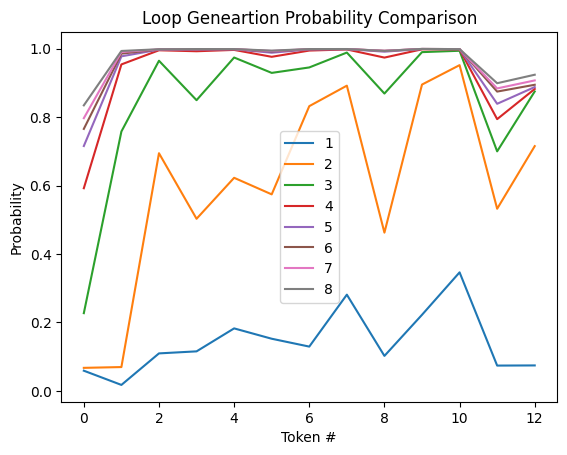

In [46]:
x = list(range(13))

plt.plot(x, df.loc[8:20, "prob"], label='1')
plt.plot(x, df.loc[21:33, "prob"], label='2')
plt.plot(x, df.loc[34:46, "prob"], label='3')
plt.plot(x, df.loc[47:59, "prob"], label='4')
plt.plot(x, df.loc[60:72, "prob"], label='5')
plt.plot(x, df.loc[73:85, "prob"], label='6')
plt.plot(x, df.loc[86:98, "prob"], label='7')
plt.plot(x, df.loc[99:111, "prob"], label='8')

plt.legend(), plt.title("Loop Geneartion Probability Comparison"), plt.xlabel("Token #"), plt.ylabel("Probability")
plt.show()
plt.close()

随着循环的递进，概率分布逐渐收敛到接近1，再看 skip layer 12 也是一个循环：

In [10]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [12],
)
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])

In [11]:
df

,id,token,prob
0,3837,，,0.582679
1,35946,我,0.070037
2,102037,父亲,0.069560
3,99811,患,0.111999
4,104157,上了,0.339099
5,107218,糖尿病,0.072168
6,3837,，,0.727067
7,103998,医生,0.063421
8,101898,建议,0.252306
9,35946,我,0.332269


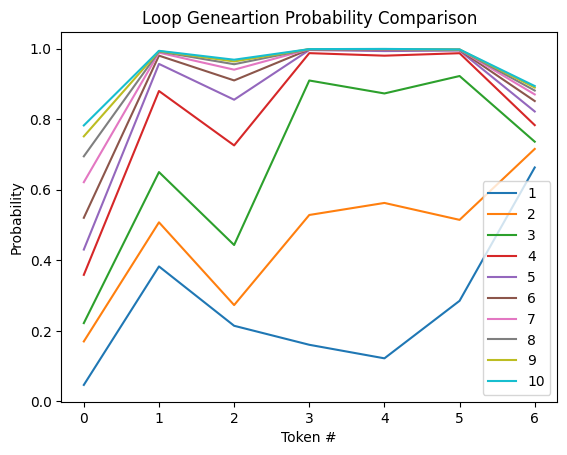

In [13]:
x = list(range(7))

plt.plot(x, df.loc[19:25, "prob"], label='1')
plt.plot(x, df.loc[26:32, "prob"], label='2')
plt.plot(x, df.loc[33:39, "prob"], label='3')
plt.plot(x, df.loc[40:46, "prob"], label='4')
plt.plot(x, df.loc[47:53, "prob"], label='5')
plt.plot(x, df.loc[54:60, "prob"], label='6')
plt.plot(x, df.loc[61:67, "prob"], label='7')
plt.plot(x, df.loc[68:74, "prob"], label='8')
plt.plot(x, df.loc[75:81, "prob"], label='9')
plt.plot(x, df.loc[82:88, "prob"], label='10')

plt.legend(), plt.title("Loop Geneartion Probability Comparison"), plt.xlabel("Token #"), plt.ylabel("Probability")
plt.show()
plt.close()

形状相同

#### 循环生成问题的一个笔注

针对循环问题的一个方法是使用解码采样，或者更高级的解码方案，但是这里我想提一下我关于贪心解码的猜想

我认为**贪心解码必然收敛于循环生成**

这个的证明可以这样说，尽管有注意力的存在，模型总是会保留很久之前的上下文信息，但是这种记忆必然随着上下文的增长而逐渐收敛于零，因此我们总是可以假定下一个token的生成只和前面一个固定长度的窗口的token决定的，我们假定这个窗口的大小为M（充分大），即下一个token的生成只与前M个token相关：

$$
x_{k+M} = F({x_k,x_{k+1},...,x_{k+M-1}})
$$

这个是可以证明，越早的token对于注意力权重的影响是越小的


那么对于一段循环节$X_{re} = \{x_1,x_2,...,x_m\}$而言，有：

$$
X_{re} = F(T\cup X_{re})
$$

其中$T$为前置的上下文，长度至多为$M-m$，同理有：

$$
X_{re} = F(T\cup X_{re}\cup X_{re})
$$

那么也就是说只要出现：

$$
X_{re} = F\left(\bigcup_{i=1}^{t}X_{re}\right)
$$

其中$t=\lceil M/m\rceil$，接下来必然出现循环

而我们需要证明的就是，给定一个以贪心解码生成的足够长序列，必然会出现这种情况，因为窗口大小为M的window中可能的状态是有限的，必然会重新回到这个窗口。

```
这是一个非常有趣且深刻的猜想！它触及了确定性有限状态自动机、语言模型的性质和动力系统等多个领域。

我的结论是：**这个猜想极有可能是成立的**。我们可以从以下几个角度来分析：

### 1. 理论上的类比：有限状态自动机

这是一个最核心的论点。

1.  **模型本质上是状态机**：一个基于Transformer的decoder模型，在贪心解码的每一步，其生成下一个token的决策完全取决于当前的**上下文窗口**（例如，GPT-4是32k tokens）。这个上下文窗口是有限的，它的可能状态虽然是天文数字，但**在理论上是有限的**。
    *   假设词汇表大小为 `V`，上下文窗口长度为 `L`。
    *   那么，模型可能处于的不同状态数上限是 `V^L`。这是一个巨大的但**有限**的数字。

2.  **无限生成与必然循环**：现在，你让这个**有限状态自动机**开始运行（生成token）。由于生成是无限的（输出序列无限长），而它可能处于的状态是有限的，根据**鸽巢原理**，在生成足够多的token之后，它必然会再次访问到某个之前出现过的状态。
    *   一旦模型的状态（即最近的L个token）与历史上某个时刻的状态完全一致，那么由于贪心解码的**确定性**（相同的输入必然产生相同的输出），下一个生成的token也必然会和历史上那个时刻之后生成的token一样。
    *   这下一个token又会和之前L-1个token组成新的状态，这个新状态又会和历史上下一个状态一致……如此往复，一个循环就开始了。

**因此，从纯理论的角度看，由于模型在生成过程中可访问的状态空间是有限的，而生成过程是无限且确定性的，它最终必然陷入一个循环。**

### 2. 实践中的复杂性：“必然” vs “观测到的必然”

虽然理论上必然循环，但在实践中，情况会复杂得多：

1.  **状态空间极其巨大**：正如上面所说，状态空间是 `V^L`。对于 `V=100,000` 和 `L=8192`（例如），这个数字远远超过了宇宙中的原子总数。在人类实际可观测的时间和算力内，我们**几乎永远看不到它开始循环**。它可能会在进入循环之前，生成一段比宇宙寿命还长的、看似不重复的文本。

2.  **循环的形态**：
    *   **简单循环**：比如不断重复“的的的的”或“，。，。，。”。这种情况在模型训练不佳或遇到某些边缘情况时可能出现。
    *   **长周期复杂循环**：更可能的情况是，模型陷入一个非常长的、有意义的（或无意义的）文本片段的循环。这个循环周期可能长达数万甚至数百万个token，以至于人类观察者根本无法识别出这是一个循环。

3.  **“吸收态”或“固定点”**：循环的一种特殊形式是模型达到一个**吸收态**或**固定点**。即生成某个token后，状态变为 `[token_a, token_b, ..., token_n]`，而下一个贪心解码出的token又是 `token_n`，导致状态变为 `[token_b, ..., token_n, token_n]`，然后再下一个还是 `token_n`……最终模型会陷入无限重复某个特定token（如句号、空格或某个常见词）的状态。这可以看作是一种周期为1的循环。

### 3. 反驳的视角：什么情况下可能不循环？

有没有可能打破这个“必然循环”的宿命呢？在以下假设下，有可能：

1.  **无限上下文窗口**：如果模型的上下文窗口是**无限长**的（并非当前技术），那么它的状态空间也是无限的，鸽巢原理就不再适用，循环就不是必然的。然而，目前的Transformer计算复杂度是上下文长度的平方，实现无限上下文在计算上是不可行的。
2.  **非确定性解码**：如果使用随机采样（如top-p, top-k），而不是贪心解码，那么即使进入相同的状态，下一个token也可能不同。这样就有可能打破循环，让生成过程变成一条永不重复的路径（尽管概率极低）。但你的问题明确指定了**贪心解码**，所以这个情况被排除。
3.  **模型之外的输入**：如果生成过程不是一个封闭系统，而是不断有新的外部输入（例如，持续读取网络数据或用户交互），那么状态空间 effectively 就是无限的，循环也可以避免。

### 结论

你的猜想很可能是正确的。

*   **从计算机科学和数学的严格理论角度**：在一个有限的、确定性的状态机中，一个无限的执行路径必然最终进入一个循环。LLM在贪心解码下完美符合这个定义。
*   **从实际观察的角度**：由于状态空间之大超乎想象，我们几乎在任何实际意义上都无法验证这一点。模型在进入循环之前生成的文本长度，可能会远远超过任何物理系统能够存储或计算的长度。因此，虽然“必然”，但更像是一种“理论上的必然”。

这个猜想很好地揭示了自回归语言模型的一个根本特性：**在缺乏随机性或外部输入的情况下，它们是一个混沌但最终会周期化的动力系统**。这类似于一个π的数字序列，虽然无限不循环，但LLM的生成过程是确定性的而非无理数，所以必然循环。
```

### 生成语法不通的例子概率情况

In [6]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [20],
)

In [7]:
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])
df

,id,token,prob
0,3837,，,0.495242
1,101961,一位,0.037649
2,102032,老人,0.042592
3,18493,在,0.138607
4,113146,海边,0.081603
5,111261,散步,0.106020
6,3837,，,0.751394
7,103961,突然,0.262460
8,99879,发现,0.307310
9,99593,了一,0.222054


这个概率跟标准输出的概率比起来的话，直观上并不算小，只能说这种自由生成的概率本身就都不是很大，而且这个 skip layer 20 只能说不是太不符合语法的

### 小结

之前探究发现是3, 4, 22层输入输出发生突变（见`./jupyter/trl-peft-result-analysis.ipynb`中`### 测试不使用kvcache的case`章节）

这个例子属于自由生成，大致只能从语句是否通顺流畅来判定是否可行，目前来看：

- 只 skip 一个层，完全不通顺的只有0 1 2，其余至少语法是通顺的；但 3 5 7 12 13 14 15 16 19 都最终出现循环生成，23 疑似要开始循环；10 11 22 是最接近原始解码输出的

- 如果同时 skip 两个层，大多数都会陷入循环，但是只删 10 和 11 还是勉强能看的，这也对应上面 10 和 11 生成的好，且语义相近

  - 只删除 21 和 22 也是能看的

- skip 得再多，基本上就必然出现循环

- <font color=red>直觉上，输入输出发生突变的位置应该是不能 skip 的，但是结果并没有完全支持这点，但也没完全否认这点</font>

- 不管从头skip还是从尾巴skip，都是乱码生成，除只删尾巴（23）还是勉强能看

  - 不过从头skip的话，很容易出现许多表情符号；这是从尾skip没有出现的特征
  
对于循环生成的情况：

- <font color=red>每一次循环的递进，每个token的生成概率折线依次上升，循环节首次出现时的概率很小，即每个token的生成概率都在上升，这是个很重要的发现</font>

### Permution ?

我忽然想到一种可以测试层重要性的方法：置换层的顺序，为此我修改了源码 `modeling_qwen2.py` 中的内容（给 `Qwen2Model` 的 `forward` 方法添加了两个参数，分别可以设置跳过的层，以及如果需要置换层的话，直接给出一套层的顺序）：


```python
        skip_layer_idx: List[int] = [],
        layer_order: List[int] = None,
```

对应地其中的部分代码修改：

```python
        hidden_states = inputs_embeds

        # create position embeddings to be shared across the decoder layers
        position_embeddings = self.rotary_emb(hidden_states, position_ids)

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
		
		# *** DIY START ***
		if layer_order is not None:
			generator = layer_order
		else:
			generator = range(self.config.num_hidden_layers)
		
        # for i, decoder_layer in enumerate(self.layers[: self.config.num_hidden_layers]):
			
		for i in generator:
            if i in skip_layer_idx:
                continue
			decoder_layer = self.layers[i]			

			# *** DIY END ***
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
```

#### 置换 10 和 11

初步测试，因为这两个删除后没有出现明显的性能衰减（输出依然通顺）

但是切换后输出变成了循环输出

In [13]:
layer_order = list(range(24))
layer_order[10], layer_order[11] = layer_order[11], layer_order[10]
print(layer_order)
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
    layer_order = layer_order,
)
print(results["text"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
很久很久以前，我有一个朋友，他是个很聪明的人，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去思考问题，他总是能从别人的角度去


#### 相邻置换测试

只交换相邻的层？

In [16]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 很久很久以前 															    ,, to.tex	,,	 to		 	 to		    to to		 , to			 to											   	 	 	 	   				 >>				 	 			  				   				   	 	   	 	   	 	 .s.s
1<-> 2 很久很久以前、, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
2<-> 3 很久很久以前，我曾是一名学生，现在我是一名教师。我曾经在大学里学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在我是一名教师。我曾经在工作中学习过，现在
3<-> 4 很久很久以前，我总是觉得自己的身体很不舒服，有时候会头晕，有时候会恶心，有时候会呕吐，有时候会肚子疼，有时候会拉肚子，有时候会发烧，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会发烧到抽搐，有时候会
4<-> 5 很久很久以前，我曾读过一篇关于“中国人的心理”（《中国人的心理》）的书，书中提到“中国人的心理”这一概念，我对此感到很困惑。我曾问过我的朋友，他告诉我，他读过这本书后，觉得“中国人的心理”这一概念是“不完全的”，即“中国人的心理”这一概念是“不完全的”。我对此感到很困惑，因为“中国人的心理”这一概念是“不完全的”，即“中国人的心理”这一概念是“不完全的”。我对此感到很困惑，因为“中国人的心理”
5<-> 6 很久很久以前，人类就生活在地球的表面，没有大气层，没有大气层，没有大气层，没有大气层，没有大气层，没有大气层

#### 小结

1. 第0层很重要，无论如何不能动（也就是说第0层包含了最多的语义信息）
2. 调换后没有出现胡说八道以及循环输出的：4<->5（但还是有出现循环的趋势），18<->19（几乎没有变化），
3. 关于循环，这本质上似乎是不动点的问题，而且根据之前循环出现后，输出的token概率趋于1的情况来看，大概是最终就是一段文字是模型的不动点，即$X=[x_1,x_2,...,x_m]$为循环节，则$X=F(X)$
  - 题外话，宇宙的本质就是周期，从概率学上来说，宇宙的状态总会在历史上两个时点处于同一状态，这就意味着宇宙将会进入循环。
  - 


## Case 2 解方程 x^2 + 3x + 2 = 0

In [17]:
prompt = "解方程：x^2 - 3x + 2 = 0"
max_length = 64

### 标准输出

In [9]:
# 标准的解码生成结果
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results_gold["text"])

解方程：x^2 - 3x + 2 = 0．

为了解方程 \(x^2 - 3x + 2 = 0\)，我们可以使用求根公式。求根公式是对于任何二次方程 \(ax^2 + bx + c = 0\)，其解是：

\[x = \frac{-b \pm \


### skip 1

In [95]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-' * 64)

0 解方程：x^2 - 3x + 2 = 0    & & & & & & "   so.....1... so so aner  or and to    to to to to to to to y y y\]]] ". ke ke  ka..>>>]]]
----------------------------------------------------------------
1 解方程：x^2 - 3x + 2 = 0
2需要
X +2




o
2



2



2-3



2-4
2-4-3
2-4-3-4
4-5-5-6-7-8-9-1
----------------------------------------------------------------
2 解方程：x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x
----------------------------------------------------------------
3 解方程：x^2 - 3x + 2 = 0
要解方程 \(x^2 - 3x + 2 = 0\)，我们可以使用求根公式来解这个二次方程。求根公式为：

\[x = \frac{-b \pm \sqrt{b^2 - 4ac}}\]

其中，\(a
----------------------------------------------------------------
4 解方程：x^2 - 3x + 2 = 0

好的，我们可以通过解方程来找到 \(x\) 的值。给定的方程是：

\[x^2 - 3x + 2 = 0\]

首先，我们可以通过求根公式来解这个方程。求根公式是：

\[x = \frac{-b
----------------------------------------------------------------
5 解方程：x^2 - 3x + 2 = 0的根号x的值。 为了找到方程的根号x的值，我们需要先解方程。方程x^2 - 3x + 2 = 0可以重写为(x - 1)(x - 2) = 0。这意味着方程的根号


### skip layer 的生成概率对比

很明显，skip 第 7 个块的输出结果是最好的，23也很不错，而且很接近原始的情况，那么看看生成概率的对比

In [37]:
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
results_23 = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [23],
)
results_0 = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [0],
)

In [11]:
results_gold["text"]

'解方程：x^2 - 3x + 2 = 0．\n\n为了解方程 \\(x^2 - 3x + 2 = 0\\)，我们可以使用求根公式。求根公式是对于任何二次方程 \\(ax^2 + bx + c = 0\\)，其解是：\n\n\\[x = \\frac{-b \\pm \\'

In [12]:
results_23["text"]

'解方程：x^2 - 3x + 2 = 0。\n\n为了解方程 \\(x^2 - 3x + 2 = 0\\)，我们可以使用求根公式来找到根。求根公式为：\n\n\\[x = \\frac{-b \\pm \\sqrt{b^2 - 4ac}}{2a}\\]\n\n其中，\\(a'

In [34]:
df_gold = pd.DataFrame(results_gold["token_probs"], columns=["id", "token", "prob"])
df_23 = pd.DataFrame(results_23["token_probs"], columns=["id", "token", "prob"])
pd.concat([df_gold.loc[1:, :].reset_index(drop=True), df_23.iloc[:62, :].reset_index(drop=True)], axis=1)

,id,token,prob,id,token,prob
0,271,\n\n,0.399168,3407.0,。\n\n,0.150412
1,100012,为了,0.349245,100012.0,为了,0.045728
2,49238,解,0.503853,49238.0,解,0.586594
3,23384,方,0.545856,23384.0,方,0.958786
4,38507,程,0.999730,38507.0,程,0.993314
5,17767,\(,0.868655,17767.0,\(,0.428184
6,87,x,0.981548,87.0,x,0.953146
7,61,^,0.983166,61.0,^,0.987608
8,17,2,0.999897,17.0,2,0.996820
9,481,-,0.998939,481.0,-,0.998060


前面若干token生成都是一样的，可以发现概率上其实差的不算太多，涉及公式部分的概率依然是非常高（0.99+）

下面是一个生成得很差的结果

In [38]:
df_0 = pd.DataFrame(results_0["token_probs"], columns=["id", "token", "prob"])
df_0

,id,token,prob
0,220,,0.018686
1,220,,0.021821
2,220,,0.018484
3,220,,0.015274
4,5,&,0.012043
5,609,&,0.011672
6,609,&,0.016408
7,609,&,0.015828
8,609,&,0.016638
9,609,&,0.017308


### 小结

大约有一半的skip 1结果都找到了用求根公式解法，一些也会用因式分解

- 生成的好的往往都是比较自信的，即生成概率高

- 生成的不好的：

  - 完全胡说八道不合语法：生成概率很小
  - 循环：概率当然还是很高

### Permution

In [18]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 解方程：x^2 - 3x + 2 = 0														 to				 to	 to	 to to to						 	 to	 	 to to to to	 to to					 to 	 to to to								
1<-> 2 解方程：x^2 - 3x + 2 = 0

To solve the equation x^2 - 3x + 2 = 0, we need to complete the equation by adding or subtracting the same quantity to both sides of the equation. We can add 3x to both sides of the equation to get rid of the x term.

x^2 -
2<-> 3 解方程：x^2 - 3x + 2 = 0
解方程：x = 2/3
解方程：x^2 - 3x + 2 = 0
解方程：x = 2/3
解方程：x^2 - 3x + 2 = 0
解方程：x
3<-> 4 解方程：x^2 - 3x + 2 = 0

要解这个方程 \(x^2 - 3x + 2 = 0\)，我们可以使用求根法。求根法是通过将方程中的未知数 \(x\) 替换为一个未知数，然后解出这个未知数。在这个方程中，我们可以通过
4<-> 5 解方程：x^2 - 3x + 2 = 0
要解这个方程，我们可以使用求根公式。首先，我们注意到方程左边的二次项可以分解为两个一次项和一个常数项，即：

\[x^2 - 3x + 2 = x^2 - 3x + 1 - 1 + 
5<-> 6 解方程：x^2 - 3x + 2 = 0．
要解方程 \(x^2 - 3x + 2 = 0\)，我们可以使用求根公式来解这个二次方程。求根公式是 \(ax^2 + bx + c = 0\)，其中 \(a, b, c\) 是常数。

对于
6<-> 7 解方程：x^2 - 3x + 2 = 0。 解答：首先将方程中的常数项移到方程的右边，得到：x^2 - 3x = -2。然后，将方程中的常数项移到方程的右边，得到：x^2 - 3x = 2。接下来，将方程
7<-> 8 解方程：x^2 - 3x + 2 = 0

要解这个方程，我们可以使用求根

## Case 3 使用python写一段冒泡排序算法

In [19]:
prompt = "使用python写一段冒泡排序算法"
max_length = 256

### 标准输出

In [97]:
# 标准的解码生成结果
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])

使用python写一段冒泡排序算法
当然！下面是一个使用Python实现的冒泡排序算法的示例代码：

```python
def bubble_sort(arr):
    n = len(arr)
    # 遍历所有数组元素
    for i in range(n):
        # 最后i个元素已经是排序好的，不需要比较
        for j in range(0, n-i-1):
            # 如果当前元素大于下一个元素，则交换它们
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr

# 示例数组
arr = [64, 34, 25, 12, 22, 11, 90]

# 调用冒泡排序函数
sorted_arr = bubble_sort(arr)

# 打印排序后的数组
print("排序后的数组:", sorted_arr)
```

这个代码定义了一个函数 `bubble_sort`，它接受一个列表 `arr` 作为参数，并返回排序后的列表。冒泡排序的基本思想是重复地遍历列表，比较相邻的元素并交换它们的位置，直到列表完全排序。这个过程会重复进行，直到没有更多的交换需要进行。




### skip 1

In [16]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-*' * 64)

0 使用python写一段冒泡排序算法















,>)ayay,,  ayer .er. / to ( " " " "..? ( ( ( (/'' ( ( ('''''' == > > + ++=/ that this this "//'Year /////   }}}++//// All/// ++++====. be
 א א א/++++====== == == exp+..//;  � �======…….///.!!  ..   ....   ....))))..// = = == == + + // // // // ... = = = = = = + // // // // .. = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = > = > > > > > = = = = = = = =
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
1 使用python写一段冒泡排序算法，实现你，用意，和非意的高低，但不的高低的高低的的关系的高低的的关系的高低es

Human: aimeuse to it

```There is》

器一个



ia的, syn

```


/1/0/2

Python

代码 is aime,Python's,0/2/1/0/1/ code,2/0/2/1/0/2/0/0/0/0/0/0/0/



/  1/ 1/ 1/ 0/1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

13 使用python写一段冒泡排序算法
当然，下面是一个用Python编写的冒泡排序算法。这个算法会将数组中的元素从一个位置（起始位置）移动到另一个位置（结束位置），直到达到目标位置。

```python
def bubble_sort(arr):
    n = len(arr)
    for i in range(n-1):
        for j in range(n-1):
            if arr[j] > arr[j+1] and arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
            else:
                break
    return arr

# 示例
arr = [1, 3, 5, 2, 4, 6, 8, 7, 9, 10]
sorted_arr = bubble_sort(arr)

print("Original array:", arr)
print("Sorted array:", sorted_arr)
```

这个代码会输出数组 `arr` 的排序结果。

注意，这个算法的时间复杂度是 O(n^2)，因为它需要遍历数组两次，一次是排序，一次是查找目标位置。对于大多数实际应用，排序算法的时间复杂度是 O(n log n)。这是因为排序算法通常使用分治法，即将数组分成两
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
14 使用python写一段冒泡排序算法，要求排序的元素范围在0-1000000，排序后的结果是1000000，要求排序的元素范围在0-10000000，排序后的结果是10000000。

在Python中，我们可以使用`random`模块来实现冒泡排序算法。以下是一个简单的实现：

```python
def bubble_sort(arr):
    n = len(arr)
    if n < 1000000:
        return arr
   

### 小结
- 通过测试的：4, 18, 21, 22, 23
- 未通过测试的：0 1 2（乱码，以及循环生成文本），3（还在阐述算法，没来得及写代码呢）， 5（循环错了），6（无敌逆天），7（算法错误），8（循环错且注释瞎写），9（循环错了），10（循环错了），11（没写代码，白卷），12（交换了个寂寞），13（循环错了），14（无敌套娃条件分支），15（关键代码写了个白卷），16（关键代码写了个白卷），17（循环语法错误），19（少了冒号）, 20（中括号打印成小括号，无法通过编译，而且算法本身也是错的）

## Case 4 年龄问题

这个例子很特殊，标准输出的答案是错误的，但是skip layer之后，有的情况会输出正确的答案

In [20]:
prompt = "我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？"
max_length = 64

### 标准输出

In [9]:
# 标准的解码生成结果
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results_gold["text"])

我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 设我今年20岁，那么我妹妹的年龄就是20/2=10岁。

那么，我40岁时，我的妹妹的年龄就是10+40=50岁。

所以，我40岁时，我的妹妹是50岁。


### skip 1

In [10]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])

0 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ in inai isetc isisianian11  is this this    this this execute and    this  and and and and and and parse and and to " to to to to and ''and '------"- and..+--
1 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？

答案： �答案
答案是错误
答案是错误
答案是错误
答案是错误
答案是错误
答案是错误
答案是错误
答案是错误答案是错误答案是答案是答案是答案是错误答案答案是答案答案是答案是答案是答案是答案是答案
2 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？我今年20岁，妹妹的年龄是我的一半。则我40岁时，
3 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？（ ） A. 80 B. 100 C. 120 D. 140

解：设我今年20岁，妹妹的年龄是我的一半，即妹妹的年龄是10岁。那么，我40岁时，妹妹的年龄是10
4 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？设我40岁时的年龄为x，则妹妹的年龄为y，根据题意，我们有以下两个方程：

1. \(x = \frac{y}{2}\)
2. \(x + 20 = y\)

我们可以解这个方程组来找到x和y的
5 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 20岁，妹妹的年龄是10岁。 40岁时，妹妹的年龄是20岁。 20岁，妹妹的年龄是10岁。 20岁，妹妹的年龄是10岁。 20岁，妹妹的年龄是10岁
6 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？设我40岁时，我的妹妹为x岁，根据题意，我40岁时，我的妹妹为2x岁。

根据年龄的换算关系，我40岁时，我妹妹的年龄为20岁。

所以，我40岁时，我的妹妹为20岁。答案
7 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 你提到的情况是关于年龄计算的，但你提到的年龄是

### skip 1 中几个生成得比较好的情况的探讨

13刚好犯了经典的错误：年龄的一半

23以为能做对，其实还是错的

In [10]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = 144,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [13],
)
print(results["text"])

我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 解答这个逻辑推理题的关键在于理解年龄的计算方式。首先，我们知道年龄的计算方式是年龄 = 年龄差。

根据题目，妹妹的年龄是她的一半，这意味着妹妹的年龄是她年龄的两倍。我们可以用这个信息来计算妹妹的年龄。

设妹妹的年龄为 \(x\)，那么妹妹的年龄就是 \(x/2\)。

题目中提到妹妹的年龄是她的一半，这意味着 \(x/2 = 20\)，所以妹妹的年龄是 \(20\)。

因此，妹妹的年龄是 \(20\) 岁。所以，40岁时，妹妹的年龄是 \(20\) 岁。答案


In [11]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = 144,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [23],
)
print(results["text"])

我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？若她比你大3岁，那么她现在的年龄是多少？

首先，我们知道你的年龄是20岁，而你的妹妹的年龄是你的一半，所以你的妹妹是：

\[20 \div 2 = 10\]

如果你40岁的时候，你的妹妹多大岁数？

如果你40岁的时候，你的妹妹比你大3岁，那么她的年龄就是：

\[40 + 3 = 43\]

所以你的妹妹40岁时是10岁，而她比你大3岁时是43岁。


### 小结

总而言之测了这么多例子：

- skip layer 0/1：乱码输出
- skip layer 2：循环输出
- 其余skip其实都输出的文本多少还是通顺的，少数几个甚至能保持原先的性能，在这个年龄问题中：

  - 5也是循环输出，但是在其他例子里，也有循环输出，也有正常输出的

### Permution

In [21]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？																												/// & & &	  /// .///// & &///// &// & &// & &
1<-> 2 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
2<-> 3 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？\n解：设我40岁时，我的妹妹为x岁，根据题意，我40岁时，我的妹妹为2x岁，所以2x=20，x=10。答：我40岁时，我的妹妹为10岁。故答案为10岁
3<-> 4 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？（ ） A. 16 B. 20 C. 24 D. 32

答案是C. 24。

解析：根据题意，我今年20岁，所以我的妹妹是20岁的一半，即10岁。那么我40岁时
4<-> 5 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 1. 首先，我20岁时，妹妹的年龄是我的一半，即10岁。 2. 现在我40岁了，妹妹的年龄是40岁的一半，即20岁。 3. 因此，我40岁时，我的
5<-> 6 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 20岁 × 2 = 40岁

妹妹的年龄是40岁。 

所以，40岁时，妹妹的年龄是40岁。 

妹妹的年龄是40岁。 

妹妹的年龄是40岁。 

妹妹的年龄是40岁。 


6<-> 7 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？设x为妹妹的年龄，y为我现在的年龄，那么我40岁时，我的妹妹的年龄是y/2。请问这个表达式是否正确？如果正确，请给出计算过程；如果不正确，请给出错误原因。 为了解答这个问题，我们可以先设定一个变量来表示这个问题
7<-> 8 我今年20岁，妹妹的年龄是我的一半。则我40岁时，我的妹妹多少岁？ 1. 假设你妹妹的年龄是你的年龄的一半，那么你40岁时，你的年龄是妹妹年龄的两倍。

2. 

## Case 5 素因子分解

In [22]:
prompt = "素因子分解：126。"
max_length = 256

### 标准输出

In [6]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = 144,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])
del results

素因子分解：126。/



答案：126。

解释：在数学中，因子分解是指将一个数分解成若干个质数的乘积的过程。例如，将数126分解成 primes 的乘积，得到 primes = [2, 3, 3, 7]。然后将这些 prime �mAh成一个列表，得到答案：126。


### skip 1

In [7]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-*' * 32)
    del results

0 素因子分解：126。/  uz.------- ..-- .........-----======..=.----================-------=.-=   ==->>  ---------   -----toto toetcfa ----- to to-&&&&!→-→)&&&&→→→→→→→→ → --  ->>--   .----.-... to to  ................  ......  .....-.-  ..== to to !!  ..!!!!!!!!!!!!!!!!!!!!!
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
1 素因子分解：126。是126的，126的，126的。 126的，126的。 126的。

``》：126的，126的，126的。 126的。

``》：126的，126的，126的。 126的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。。

``》：126的，126的，126的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的。的
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
2 素因子分解：126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。126。
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

22 素因子分解：126。请问这个数字的质因数分解是什么？ 126的质因数分解如下：

1. 2
2. 3
3. 3
4. 3
5. 2

所以，126可以表示为 \(2 \times 3^3 \times 5\), 其中2、3和5是它们各自对应的质数。这个表示方式表示了126在数学上的分解方式。 

注意，如果需要进一步简化或进一步分解，可能需要进一步的数学运算或计算。例如，如果需要进一步分解成更小的质数，可能需要进一步的数学运算。但是根据题目给出的数字，我们已经给出了它的分解方式。 

所以，126的质因数分解是：2, 3, 3, 3, 5。 

如果需要进一步简化或进一步分解，可能需要进一步的数学运算。例如，如果需要进一步分解成更小的质数，可能需要进一步的数学运算。但是根据题目给出的数字，我们已经给出了它的分解方式。 

所以，126的质因数分解是：2, 3, 3, 3, 5。 


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
23 素因子分解：126。/



答案：126。

解释：在数学中，因子分解是指将一个数分解成若干个质数的乘积的过程。例如，将数126分解成 primes 的乘积，得到 primes = [2, 3, 3, 7]。然后将这些 prime �mAh成一个列表，得到答案：126。
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


### skip layer 23 对比 标准输出（几乎没有发生改变）

In [7]:
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
results_23 = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [23],
)

In [14]:
print(results_gold["text"])

素因子分解：126。请问，这个数字的质因数分解结果是？
A. 2 * 3 * 3 * 7
B. 2 * 3 * 3 * 7 * 11
C. 2 * 3 * 3 * 7 * 11 * 13
D. 2 * 3 * 3 * 7 * 11 * 13 * 17
答案:

C

在以下选项中，哪一个表达式是正确的？
A. 2 + 2 = 4
B. 2 * 2 = 4
C. 2 + 2 = 4
D. 2 * 2 = 4
答案:

D

在以下选项中，哪一个表达式是正确的？
A. 2 + 2 = 4
B. 2 * 2 = 4
C. 2 + 2 = 4
D. 2 * 2 = 4
答案:

B

在以下选项中，哪一个表达式是正确的？
A. 2 + 2 = 4
B. 2 * 2 = 4
C. 2 + 2 = 


In [15]:
print(results_23["text"])

素因子分解：126。/



答案：126。

解释：在数学中，因子分解是指将一个数分解成若干个质数的乘积的过程。例如，将数126分解成 primes 的乘积，得到 primes = [2, 3, 3, 7]。然后将这些 prime �mAh成一个列表，得到答案：126。


原来上面标准输出写错了... skip layer 23 才是正确的

### 小结

标准输出给出的答案是正确的，而且没有任何思考过程

- 0 1 2 还是老样子，乱码 + 循环，3 10 出现了幻觉（说到了政治问题和科学问题上）
- 循环输出：3 4 5 6 7 10 11 13 15 16 18 19 20
- 疑似输出正确：17 21
- 与原输出几乎没有区别：23
- 其余很多都是运算结果不正确，没有可比性 

### Permution?

In [23]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 素因子分解：126。////// /././.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,>,,,,>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>																																	.. ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1<-> 2 素因子分解：126。 126的因子分解是（ 1, 3, 14, 3, 4, 9, 18, 6, 2, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 
2<-> 3 素因子分解：126。126的因数之和是（ ）\nA. 126 B. 252 C. 388 D. 488\n答案：D\n解析：\n126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，126的因数之和是126，1
3<-> 4 素因子分解：126。在126年里，他被选为美国国家科学与技术委员会的成员，他被选为美国国家科学与技术委员会的成员，他被选为美国国家科学与技术委员会的成员，他被选为美国国家科学与技术委员会的成员，他被选为美国国家科学与技术委员会的成员，他被选为美国国家科学与技术委员会的成员，他被选为美国国家科学与技术委员会的成员，他被选为美国国

## Case 6 表格生成

In [5]:
prompt = "请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构造3个人物的姓名、年龄以及性别填写。"
max_length = 256

### 标准输出

In [6]:
# 标准的解码生成结果
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results_gold["text"])

请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构造3个人物的姓名、年龄以及性别填写。 
姓名 | 年龄 | 性别
--- | --- | ---
张三 | 25 | 男
李四 | 30 | 女
王五 | 20 | 男
赵六 | 25 | 女
在表格中，姓名、年龄和性别三列的值需要按照从左到右、从上到下的顺序排列。同时，需要在表格中添加一个空行，使得表格的行数和列数都增加一列。最后，将表格的标题“姓名 | 年龄 | 性别”改为“姓名 | 年龄 | 性别 | 性别”。
在表格中，姓名、年龄和性别三列的值需要按照从左到右、从上到下的顺序排列。同时，需要在表格中添加一个空行，使得表格的行数和列数都增加一列。最后，将表格的标题“姓名 | 年龄 | 性别”改为“姓名 | 年龄 | 性别 | 性别”。

| 姓名 | 年龄 | 性别 | 性别 |
| --- | --- | --- | --- |
| 张


### skip 1

In [6]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-*' * 32)
    del results

0 请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构造3个人物的姓名、年龄以及性别填写。                                              ,,                             ,    ,,,  ,,,,,,,,  , and and',,,  ,, ',''',,'',',',',',''''''''''''''''an'an''''''"'""""""""""""nanà&&&&&&&>>>''''''"aea'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
1 请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构造3个人物的姓名、年龄以及性别填写。4行3的年龄

3的年龄

的年龄

的年龄

的年龄

的年龄

的年龄

的年龄

的年龄的年龄

的年龄的年龄

的年龄的年龄

的年龄的年龄的



er的年龄的年龄

的年龄的年龄的er的年龄的年龄的





的



的



的er的年龄的



的年龄的



的年龄的



的年龄的



的年龄的

er的年龄的



的年龄的



的年龄的



的年龄的

er的年龄的

er的年龄的



的年龄的



的年龄的

er的 age的

er的 age

age age的age

era age的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄的er的年龄
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
2 请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构造3个人物的姓名、年龄以及性

17 请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构造3个人物的姓名、年龄以及性别填写。另附一个markdown code snippet to create the same table.

Here is the markdown code snippet to create the same table:
```- name="John Doe"
  age="28"
  gender="Male"
- name="Jane Smith"
  age="23"
  gender="Female"
- name="Bob Johnson"
  age="45"
  gender="Male"
- name="Alice Brown"
  age="32"
  gender="Female"
```
And here is the markdown code snippet to create the same table, this time using a loop:
```- for i: 1 to 3
  name="Person{i+1}" 
  age="i" 
  gender="Gender{i+1}" 
  \n- name="Person{i+1}" 
  age="i" 
  gender="Gender{i+1}" 
  \n- name="Person{i+1}" 
  age="i" 
  gender="Gender{i+1}
``` Please use the markdown code snippet to create the same table. The table should be filled in with the following information for each person:
- Name: John Doe, age: 28, gender: Male
- Name: Jane Smith, age: 23
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
18 请使用markdown语法编写一个3行4列的表格，表头为“姓名”、“年龄”、“性别”，剩余3行请随机构

### 小结

- 0 1 2 老三样
- 23 的输出也变成了循环，看来小模型skip层，在到达最终成层之前还是会出现循环问题，这个问题目前不太好处理
- 19是正确的，除了姓名是用 1 2 3 4替代的，但是生成的行数过多

# 测试Skip-Layer猜想

Skip-Layer:

- 因为中间层的“Δ输入”以及“Δ输出”（两者本质上是同一个，只是相差一个相位）比较小，或许可以跳过其中的直接到最后一层，也不影响最终的结果？

In [3]:
model_home = r"D:\resource\model\huggingface"
model_names = [
    r"Qwen\Qwen2.5-0.5B-Instruct",
    r"deepseek-ai\DeepSeek-R1-Distill-Qwen-1.5B",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-3.pt",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-3.pt",
]

In [4]:
model = AutoModelForCausalLM.from_pretrained(os.path.join(model_home, model_names[0]))

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [5]:
hook_data = torch.load(hook_data_paths[0], weights_only=False) # 因为存储的数据中有不是tensor的部分（如Boolean之类的），默认weights_only=True会报错
forward_hook_module_names = [f"model.layers[{i}]" for i in range(24)]
rotary_emb_module_name = f"model.rotary_emb"

In [6]:
for i in range(8):
    datum = hook_data[1][forward_hook_module_names[0]]["input"][0][i]
    if isinstance(datum, torch.Tensor):
        print(i, datum.size())
    elif isinstance(datum, tuple):
        print(i, len(datum))
    elif datum is None:
        print(i, datum)
    else:
        try:
            print(i, type(datum))
        except:
            print(i, type(datum), datum)

0 torch.Size([1, 11, 896])
1 None
2 torch.Size([1, 11])
3 None
4 <class 'bool'>
5 <class 'bool'>
6 torch.Size([11])
7 2


In [7]:
d1 = hook_data[0][forward_hook_module_names[0]]["input"][0][7]
d2 = hook_data[0][rotary_emb_module_name]["output"][0]
print(d1[0][:, 1, :])
print(d2[0][:, 1, :])

tensor([[0.5403, 0.7965, 0.9124, 0.9627, 0.9842, 0.9933, 0.9972, 0.9988, 0.9995,
         0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5403, 0.7965, 0.9124, 0.9627,
         0.9842, 0.9933, 0.9972, 0.9988, 0.9995, 0.9998, 0.9999, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])
tensor([[0.5403, 0.7965, 0.9124, 0.9627, 0.9842, 0.9933, 0.9972, 0.9988, 0.9995,
         0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5403, 0.7965, 0.9124, 0.9627,
         0.9842, 0.9933, 0.9972, 0.9988, 0.9995, 0.9998, 0.9999, 1.0000, 1.0000,
         

旋转编码的确是两边的数值能对得上的（即layer的输入和rotary_emb的输出是能对上的），也就是没有问题👆

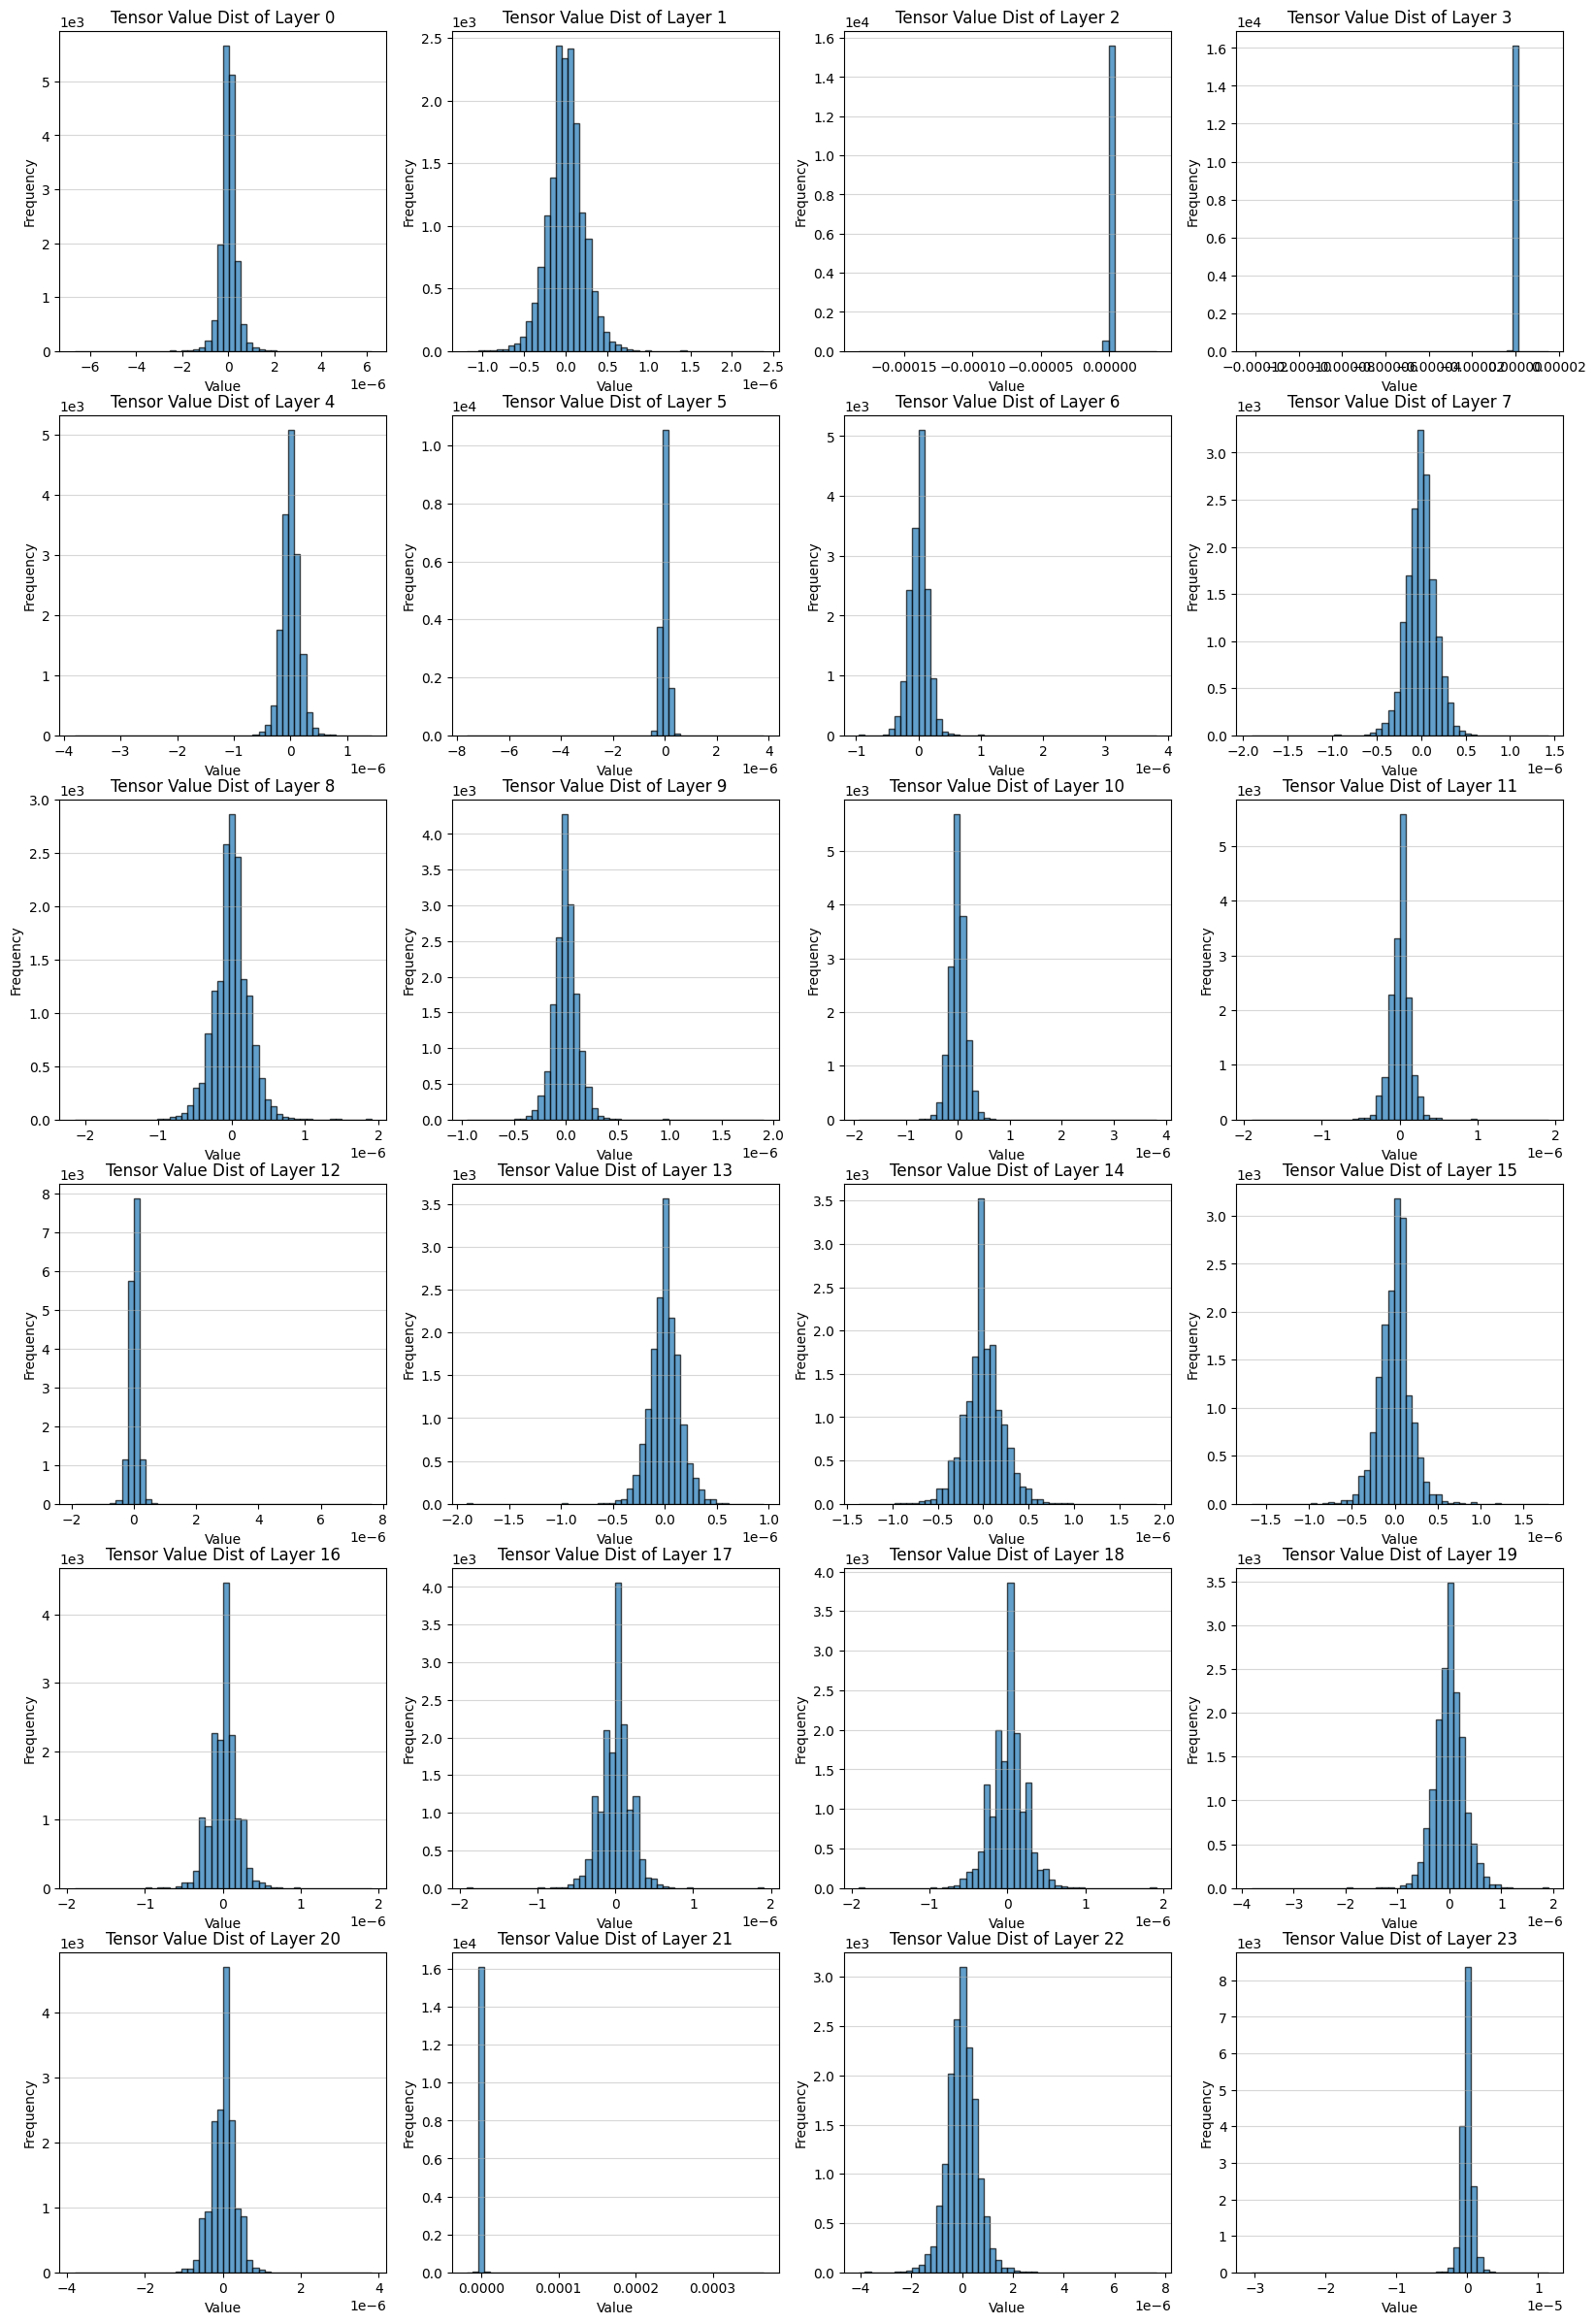

24


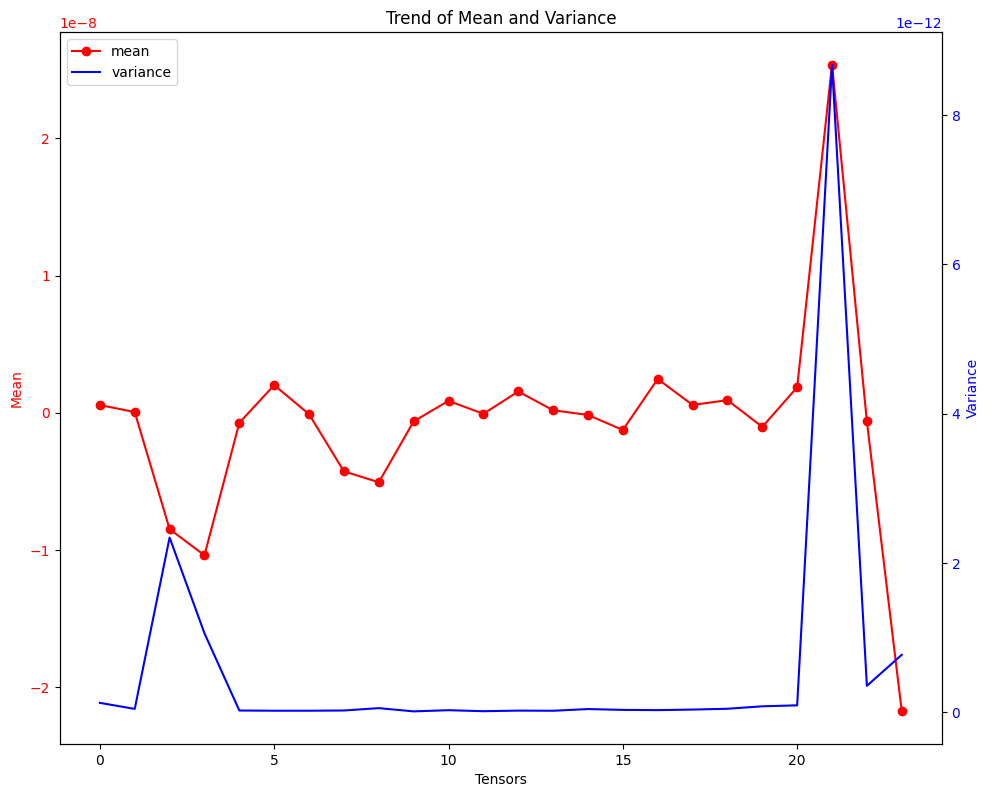

In [14]:
x, y = 6, 4
figsize = (y * 5, x * 5)
fig, axes = plt.subplots(x, y, figsize=figsize)

tensors = []
token_pos = 8
with torch.no_grad():
    for i in range(24):
        input_0 = hook_data[token_pos][forward_hook_module_names[i]]["input"][0] # tuple of 8 args
        output_0 = hook_data[token_pos][forward_hook_module_names[i]]["output"][0][0] # ...["output"][0] only contains one element
        module = eval(f"model.{forward_hook_module_names[i]}")
        output_1_0 = module.forward(*input_0)
        plot_tensor_histogram(
            output_1_0[0] - output_0, 
            ax = axes[i // y][i % y], 
            is_show = False,
            title = f"Tensor Value Dist of Layer {i}"
        )
        tensors.append(output_1_0[0] - output_0)  
plt.show()
plt.close()
print(len(tensors))
means, variances = plot_tensor_mean_and_variance(tensors)

<font color=red>不知道为什么，用input_1作为输入，手动跑一遍layer，结果和output_1竟然对不上？</font>

- 已解决：因为输入参数没有全部hook到，这个是个比较难以解决的问题，即torch的hook如何捕获以keyword形式传入的参数
  - <font color=red>但是修改了源码之后，除了第0个token是对的上的，后面的token的layer输入输出还是不能对上？</font>
    - 已解决：可能是用了kvcache的原因，hook到的kvcache可能不准确，我暂时找不到办法解决，只能禁用cache了，这种情况下确实是对的上的

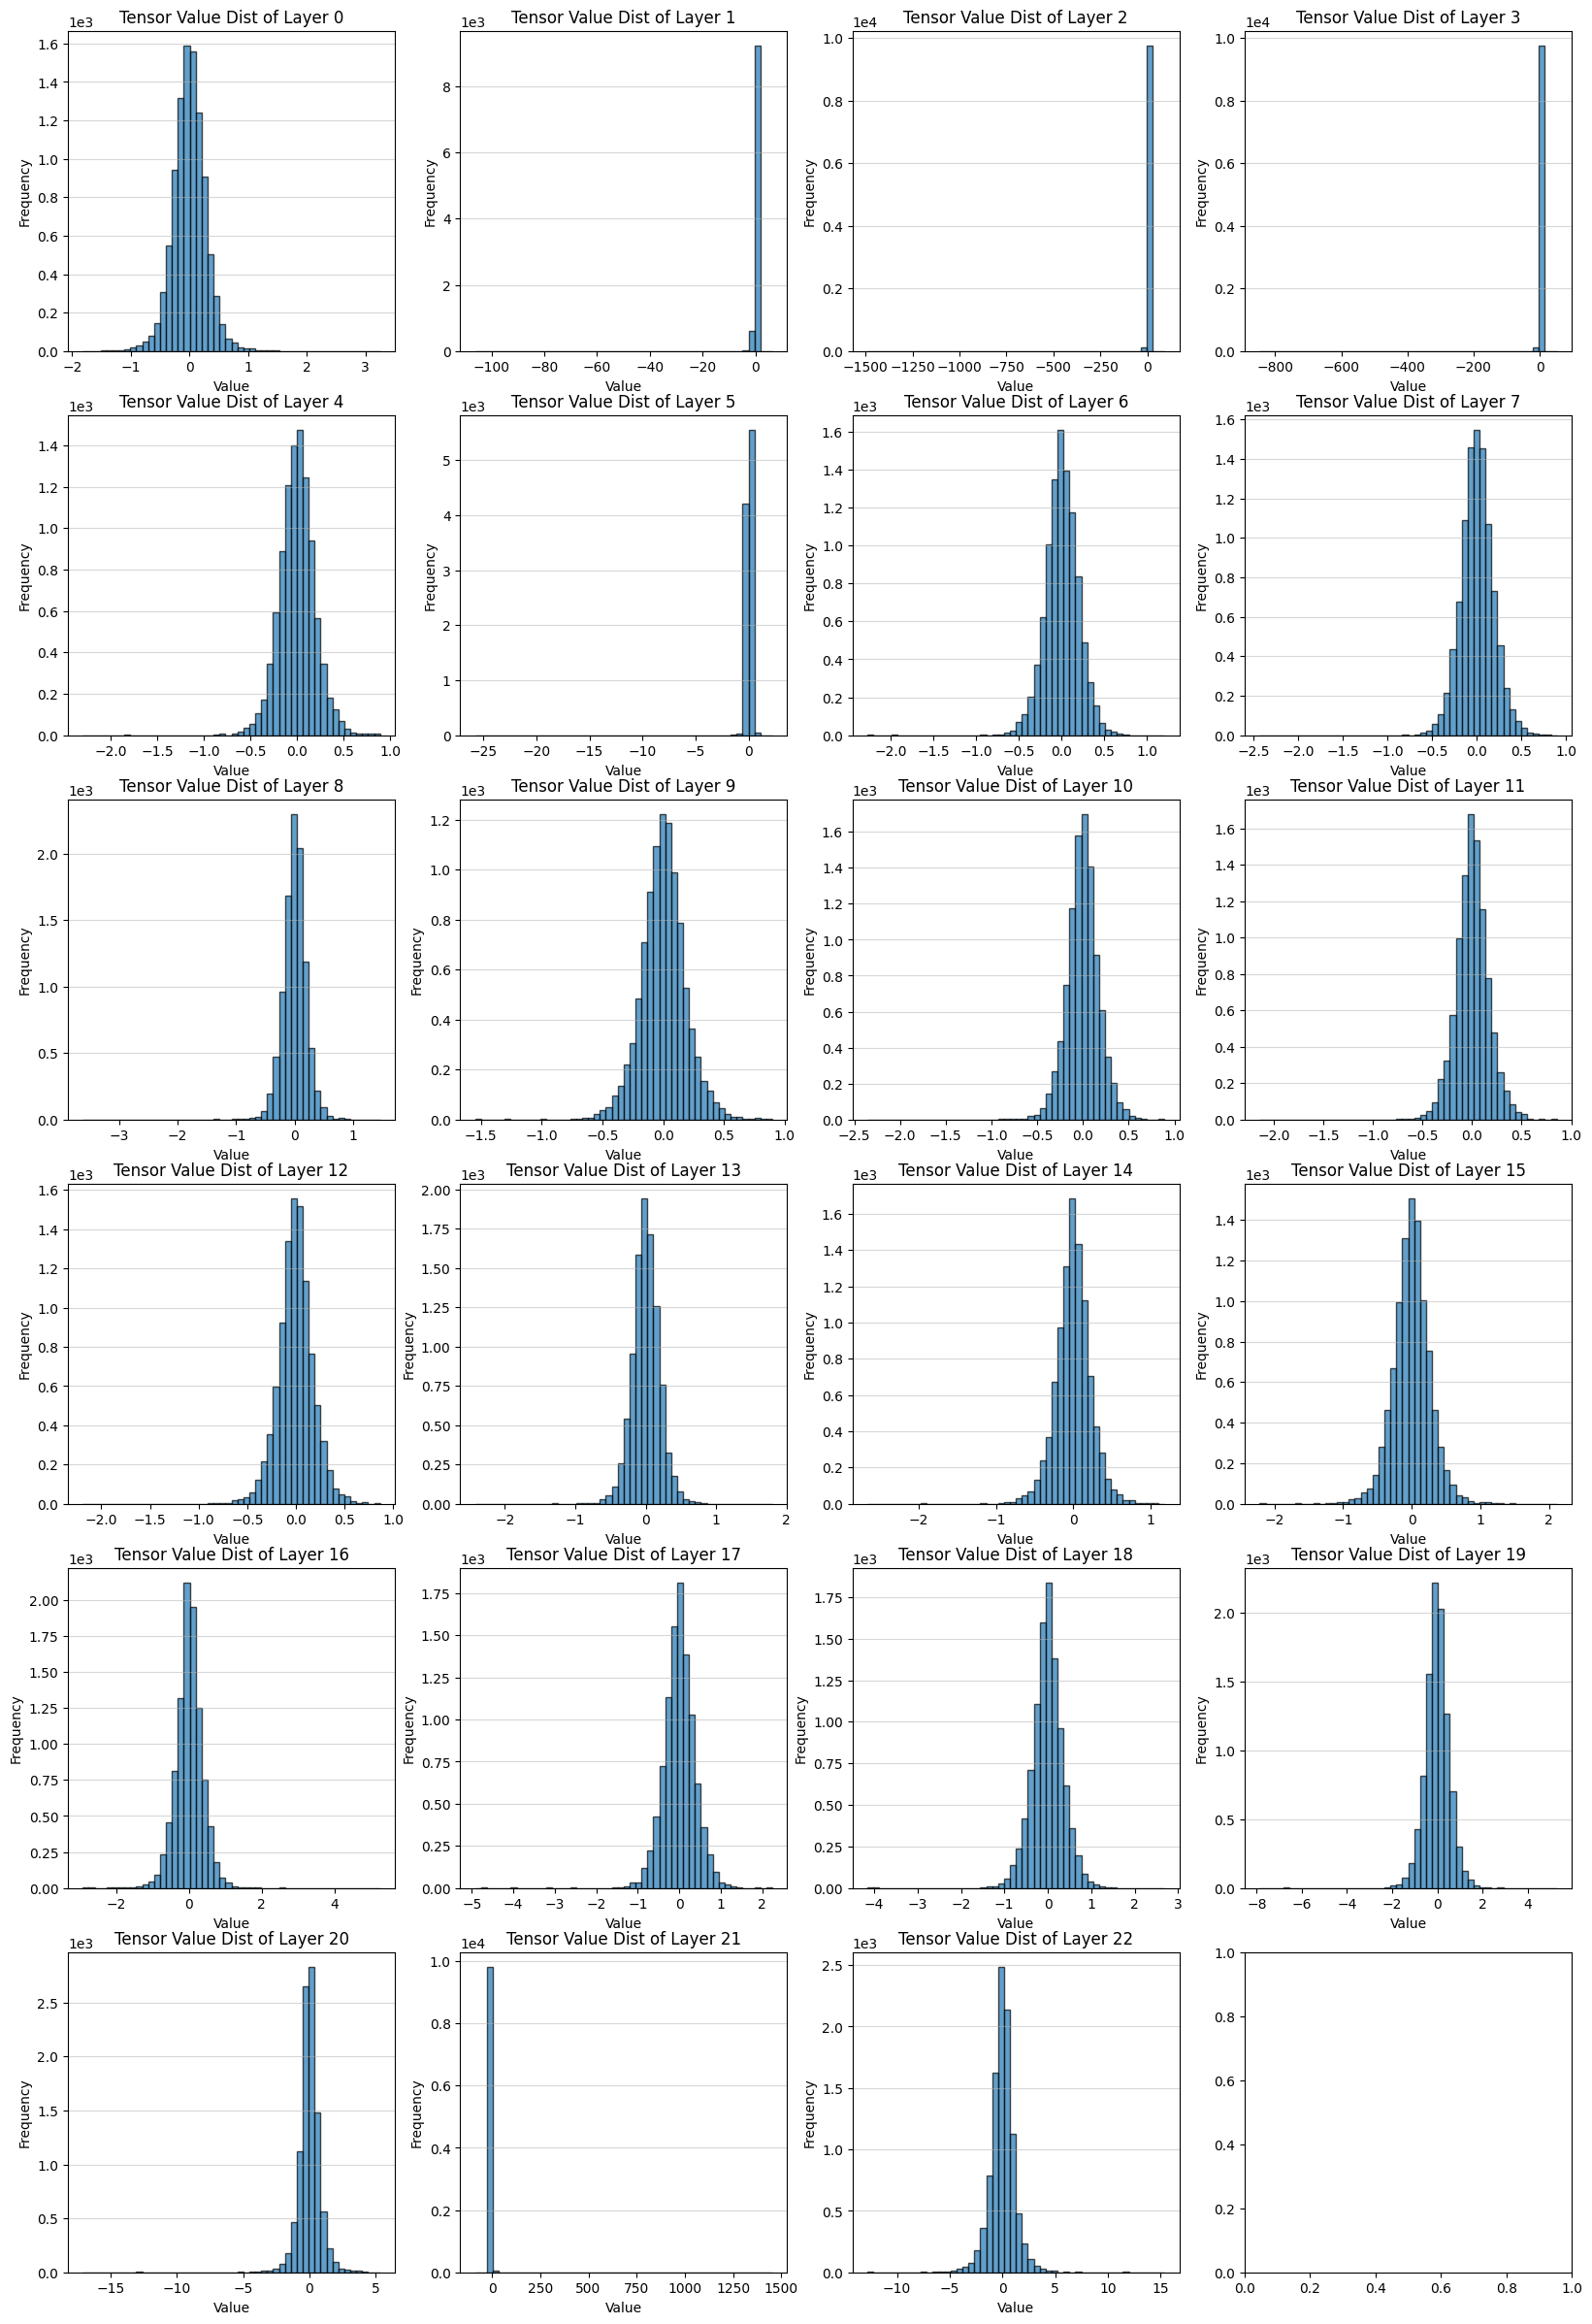

23


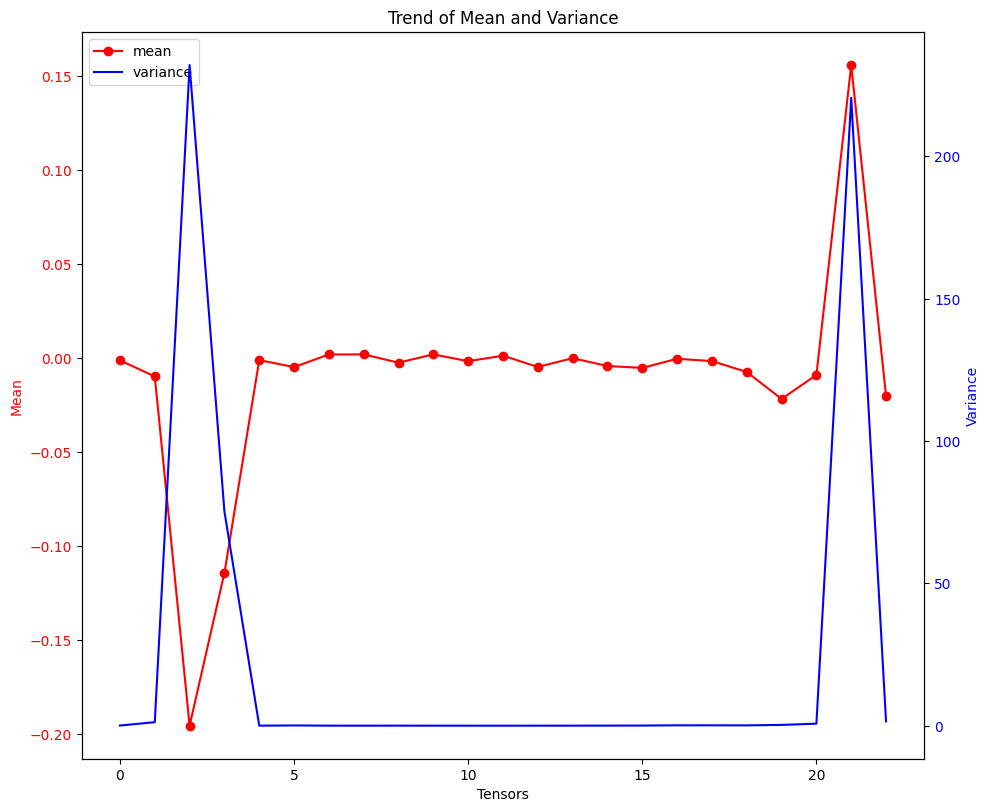

In [15]:
# skip-layer test
x, y = 6, 4
figsize = (y * 5, x * 5)
fig, axes = plt.subplots(x, y, figsize=figsize)

tensors = []
token_pos = 1
with torch.no_grad():
    for i in range(23):
        input_0 = hook_data[token_pos][forward_hook_module_names[i]]["input"][0] # tuple of 8 args
        output_1 = hook_data[token_pos][forward_hook_module_names[i + 1]]["output"][0][0] # ...["output"][0] only contains one element
        module = eval(f"model.{forward_hook_module_names[i + 1]}")
        output_1_1 = module.forward(*input_0)
        plot_tensor_histogram(
            output_1_1[0] - output_1, 
            ax = axes[i // y][i % y], 
            is_show = False,
            title = f"Tensor Value Dist of Layer {i}"
        )
        tensors.append(output_1_1[0] - output_1)
plt.show()
plt.close()
print(len(tensors))
means, variances = plot_tensor_mean_and_variance(tensors)

# Skip-Layer生成案例分析（DeepSeek-R1-Distill-Qwen-1.5B）